# Homework 4

## Loading Libraries

In [1]:
# Import Pyspark

import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-3.1.2-bin-hadoop3.2'

In [2]:
# Importing Pyspark 2

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Crosslisted_Project").getOrCreate()
from pyspark.sql.functions import approxCountDistinct, countDistinct, count, when, isnan, col, isnull

In [3]:
# Importing Libraries


# Basic Libraries #################################################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import sklearn
from sklearn import linear_model


# For Feature Engineering #########################################################################################

# For Plotting Correlation Matrix and Scatter Plot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA


# For Machine Learning Models #####################################################################################

# For Metrics/Needed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score

# For Linear Regression
from sklearn.linear_model import LinearRegression

# Ridge Regression
from sklearn.linear_model import Ridge

# Lasso Regression
from sklearn.linear_model import Lasso

# ElasticNet Regression
from sklearn.linear_model import ElasticNet

# For SVM
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score, max_error
from sklearn.svm import SVR

# Decision Tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF,RationalQuadratic,WhiteKernel, Matern, ExpSineSquared


# Personal Preference #############################################################################################
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Uploading dataset as a Pyspark Dataframe

dataset_file = 'Advertising.csv'

file_location = dataset_file
file_type = "csv"
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df_sp = spark.read.format(file_type)\
.option("InferSchema", infer_schema)\
.option("header", first_row_is_header)\
.option("sep", delimiter)\
.load(file_location)

df_sp.printSchema()

root
 |-- TV: double (nullable = true)
 |-- radio: double (nullable = true)
 |-- newspaper: double (nullable = true)
 |-- sales: double (nullable = true)



In [5]:
# Uploading Data as Pandas Dataframe

df_pd = pd.read_csv(dataset_file)
df_pd.head(5)

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


## Question 1: Check if there is any missing value in the dataset. Perform some basic exploratory data analysis. 

In [6]:
# Basic Data Analyis

df_sp.describe().toPandas()

,summary,TV,radio,newspaper,sales
0,count,200,200,200,200
1,mean,147.0425,23.264000000000024,30.553999999999995,14.022500000000003
2,stddev,85.85423631490805,14.846809176168728,21.77862083852283,5.217456565710477
3,min,0.7,0.0,0.3,1.6
4,max,296.4,49.6,114.0,27.0


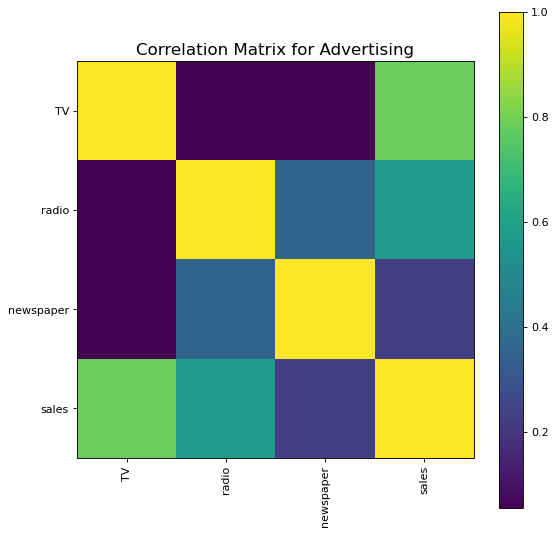

In [7]:
# Correlation Matrix

def plotCorrelationMatrix(df_pd, graphWidth):
    filename = 'Advertising'
    df = df_pd.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] 
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


plotCorrelationMatrix(df_pd, 8)

In [8]:
# Missing Percentage

def missing_calculation(df_sp, miss_percentage=0.45):
    
    missing = df_sp.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_sp.columns])
    length_df = df_sp.count()

    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True) 
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True) 
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df
    
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage] 
    
    return final_missing_df, vars_selected

missing_df, missing_vars_selected = missing_calculation(df_sp)
missing_df

,index,missing_count,missing_percentage
0,TV,0,0.0
1,radio,0,0.0
2,newspaper,0,0.0
3,sales,0,0.0


## Question 2: Using Sales as your predictor variable, implement at least Eight different regression techniques on the Advertising dataset. 

In [9]:
# Splitting the Data

TVN = 'sales' #Target Variable Name

features_X = ['TV', 'radio', 'newspaper']
X = df_pd[features_X].values
y = df_pd[TVN].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)


In [10]:
# Simple Linear Regression


# Running Model
lregressor1 = sklearn.linear_model.LinearRegression()
lregressor1.fit(X_train, y_train)

# Predicting
y_pred = lregressor1.predict(X_test)

# Results
print('Mean Square Error: ', metrics.mean_squared_error(y_test,y_pred))
print('r2 score (training): {:.3f}'.format(lregressor1.score(X_train, y_train)))
print('r2 score (test): {:.3f}'.format(lregressor1.score(X_test, y_test)))

Mean Square Error:  1.8506819941636907
r2 score (training): 0.893
r2 score (test): 0.906


In [11]:
# Ridge Regression


# Running Model
ridgeregressor = Ridge()
ridgeregressor.fit(X_train, y_train)

# Predicting
y2_pred = ridgeregressor.predict(X_test)

# Result
print('Mean Square Error: ', metrics.mean_squared_error(y_test,y2_pred))
print('r2 score (training): {:.3f}'.format(ridgeregressor.score(X_train, y_train)))
print('r2 score (test): {:.3f}'.format(ridgeregressor.score(X_test, y_test)))

Mean Square Error:  1.850678449724129
r2 score (training): 0.893
r2 score (test): 0.906


In [12]:
# Lasso Regression


# Running Model
lassoregressor = Lasso()
lassoregressor.fit(X_train, y_train)

# Predicting
y3_pred = lassoregressor.predict(X_test)

# Results
print('Mean Square Error: ', metrics.mean_squared_error(y_test,y3_pred))
print('r2 score (training): {:.3f}'.format(lassoregressor.score(X_train, y_train)))
print('r2 score (test): {:.3f}'.format(lassoregressor.score(X_test, y_test)))

Mean Square Error:  1.8162710852457409
r2 score (training): 0.893
r2 score (test): 0.908


In [13]:
# Elastic Net


# Running Model
elasticnetregressor =ElasticNet()
elasticnetregressor.fit(X_train, y_train)

# Predicting
y4_pred = elasticnetregressor.predict(X_test)

# Results
print('Mean Square Error: ', metrics.mean_squared_error(y_test,y4_pred))
print('r2 score (training): {:.3f}'.format(elasticnetregressor.score(X_train, y_train)))
print('r2 score (test): {:.3f}'.format(elasticnetregressor.score(X_test, y_test)))

Mean Square Error:  1.8326739674501105
r2 score (training): 0.893
r2 score (test): 0.907


In [14]:
# Support Vector Machine (Regression, rbf)


# Running Model
svcregressor = SVR(kernel='rbf')
svcregressor.fit(X_train , y_train)

# Predicting
y7_pred = svcregressor.predict(X_test)

# Results
print('Mean Square Error: ', metrics.mean_squared_error(y_test,y7_pred))
print('r2 score (training): {:.3f}'.format(svcregressor.score(X_train, y_train)))
print('r2 score (test): {:.3f}'.format(svcregressor.score(X_test, y_test)))

Mean Square Error:  3.117618663836202
r2 score (training): 0.820
r2 score (test): 0.841


In [15]:
# Gaussian Process Regressor (rbf)


kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10)) * RBF(length_scale=1, length_scale_bounds=(0.0, 10)) #+ RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))

# Running Model
GPRegressor = GaussianProcessRegressor(kernel=kernel)
GPRegressor.fit(X_train, y_train) 

# Predicting
y8_pred = GPRegressor.predict(X_test)

# Results
print('Mean Square Error: ', metrics.mean_squared_error(y_test,y8_pred))
print('r2 score (training): {:.3f}'.format(GPRegressor.score(X_train, y_train)))
print('r2 score (test): {:.3f}'.format(GPRegressor.score(X_test, y_test)))

Mean Square Error:  40.45877137790387
r2 score (training): 1.000
r2 score (test): -1.058


In [16]:
# Decision Tree


# Running Model
DTRegressor = DecisionTreeRegressor()
DTRegressor.fit(X_train, y_train)
    
# Predicting
y9_pred = DTRegressor.predict(X_test)

# Results
print('Mean Square Error: ', metrics.mean_squared_error(y_test,y9_pred))
print('r2 score (training): {:.3f}'.format(DTRegressor.score(X_train, y_train)))
print('r2 score (test): {:.3f}'.format(DTRegressor.score(X_test, y_test)))

Mean Square Error:  1.1111666666666666
r2 score (training): 1.000
r2 score (test): 0.943


In [17]:
# Random Forest (Max Depth = 25)


# Running Model
RFRegressor = RandomForestRegressor(max_depth= 5, random_state=0)
RFRegressor.fit(X_train,y_train)

# Predicting
y10_pred = RFRegressor.predict(X_test)

# Results
print('Mean Square Error: ', metrics.mean_squared_error(y_test,y10_pred))
print('r2 score (training): {:.3f}'.format(RFRegressor.score(X_train, y_train)))
print('r2 score (test): {:.3f}'.format(RFRegressor.score(X_test, y_test)))

Mean Square Error:  0.48102950245345905
r2 score (training): 0.993
r2 score (test): 0.976


## Question 3: Make a comparison of the prediction performance of the different algorithms implemented on Question 2.

Based off these pre-tuned models Random Forest performs the best and Gaussian Process Regression performs the worst. I am not sure why Random Forest works so well, my guess was overfitting but the r2 score for test data is also extremely high. This is a cause for research in the future. The linear regression models are ok and would work for this data set, especially if alpha is tuned. Overall most regression models would perform well on this dataset.